YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


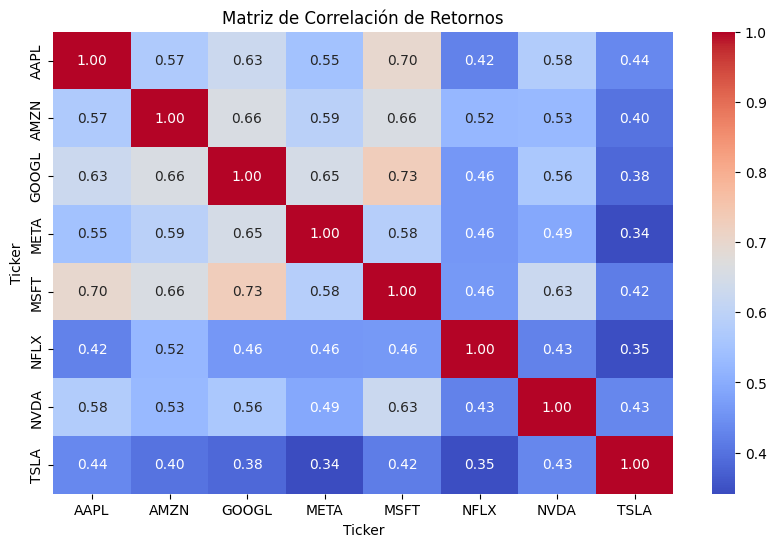

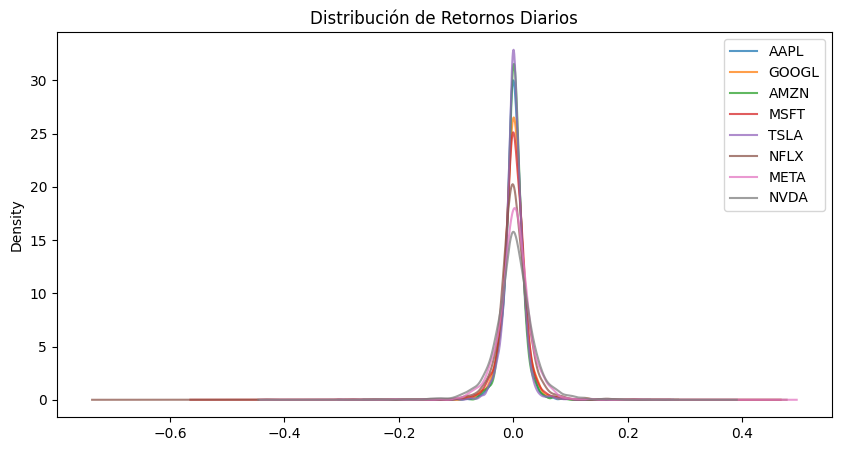

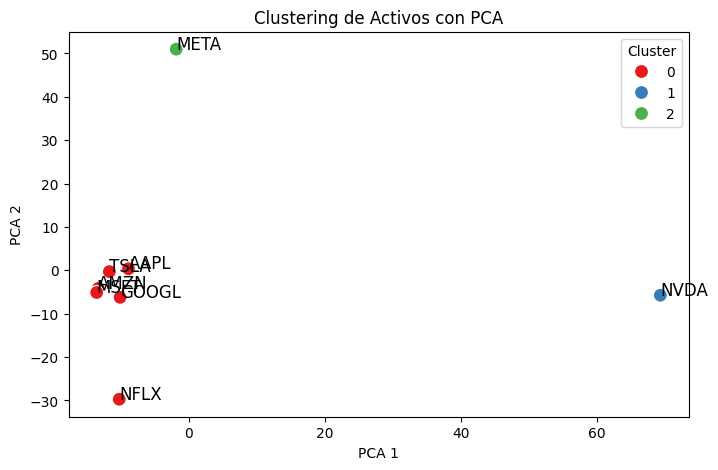

Activos Seleccionados para la Optimización de Portafolio: ['AAPL' 'NVDA' 'META']


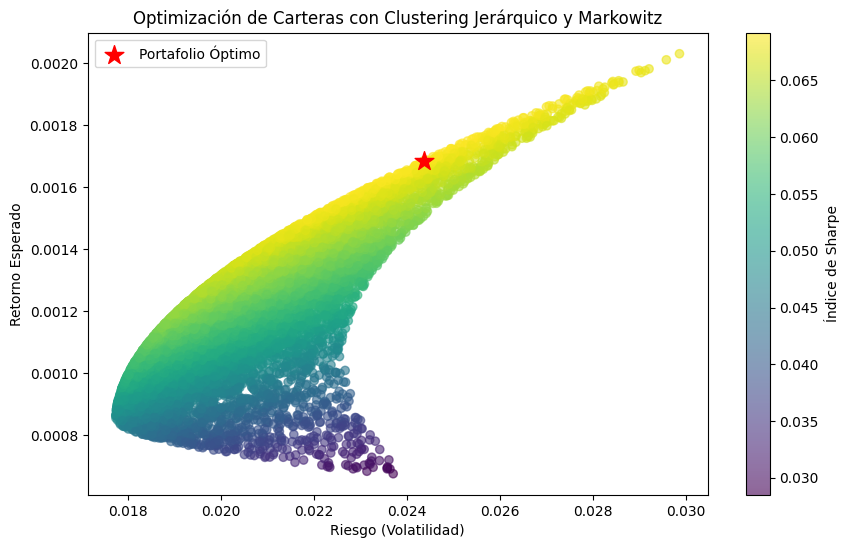

Pesos del portafolio óptimo basado en clustering jerárquico y Markowitz:
AAPL: 31.47%
NVDA: 68.31%
META: 0.22%


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Cargar datos financieros
TICKERS = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA', 'NFLX', 'META', 'NVDA']
data = yf.download(TICKERS, start="2015-01-01", end="2023-12-31")['Close']

# 2. Calcular Retornos Logarítmicos
returns = np.log(data / data.shift(1)).dropna()

# 3. Visualizar la Correlación entre Activos
plt.figure(figsize=(10,6))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación de Retornos")
plt.show()

# 4. Distribución de Retornos de cada activo
returns.plot(kind='kde', figsize=(10,5), alpha=0.75)
plt.title("Distribución de Retornos Diarios")
plt.legend(TICKERS)
plt.show()

# 5. Normalizar los datos para Clustering
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

# 6. Aplicar Clustering Jerárquico (AgglomerativeClustering)
num_clusters = 3  # Puedes ajustar este valor
agg_clust = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
labels = agg_clust.fit_predict(returns_scaled)

# 7. Visualizar Clusters con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(returns_scaled)

plt.figure(figsize=(8,5))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels, palette='Set1', s=100)
for i, ticker in enumerate(TICKERS):
    plt.text(pca_result[i,0], pca_result[i,1], ticker, fontsize=12)
plt.title("Clustering de Activos con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# 8. Seleccionar un Activo Representante de cada Cluster
cluster_df = pd.DataFrame({'Ticker': TICKERS, 'Cluster': labels})
selected_assets = cluster_df.groupby('Cluster').first()['Ticker'].values
print("Activos Seleccionados para la Optimización de Portafolio:", selected_assets)

# 9. Optimización de Carteras con Markowitz
returns_selected = returns[selected_assets]
mean_returns = returns_selected.mean()
cov_matrix = returns_selected.cov()
num_portfolios = 10000

results = np.zeros((3, num_portfolios))
weights_record = np.zeros((num_portfolios, len(selected_assets)))

for i in range(num_portfolios):
    weights = np.random.random(len(selected_assets))
    weights /= np.sum(weights)
    weights_record[i, :] = weights
    port_return = np.sum(weights * mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = port_return / port_volatility if port_volatility != 0 else 0
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio

# Encontrar el portafolio óptimo según Sharpe Ratio
max_sharpe_idx = np.argmax(results[2, :])
optimal_weights = weights_record[max_sharpe_idx, :]

# 10. Visualizar la Frontera Eficiente
plt.figure(figsize=(10,6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.6)
plt.colorbar(label='Índice de Sharpe')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=200, label='Portafolio Óptimo')
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Esperado')
plt.legend()
plt.title('Optimización de Carteras con Clustering Jerárquico y Markowitz')
plt.show()

# 11. Mostrar los Pesos del Portafolio Óptimo
print("Pesos del portafolio óptimo basado en clustering jerárquico y Markowitz:")
for asset, weight in zip(selected_assets, optimal_weights):
    print(f"{asset}: {weight:.2%}")